In [2]:
def f(x):
    return x * 3  + x **2

In [3]:
f(8)

88

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
h = 0.0001
x = 3
(f(x+h) - f(x))/h

9.000100000022826

In [2]:
a = 2
b = -3
c = 10.0


d = a*b + c
print(d)

4.0


In [3]:
h = 0.0001
d1 = a*b + c
b +=h
d2 = a*b + c


print('slope', (d2 -d1)/h)

# All correct for now.

slope 2.0000000000042206


In [10]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other),'+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0, label = 'a')
b = Value(-33.0, label = 'b')
c = Value(120.0, label = 'c')
d = a*b + c
e = Value(-55, label= 'e')
d = a*b + c + d + e
d

Value(data=53.0)

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


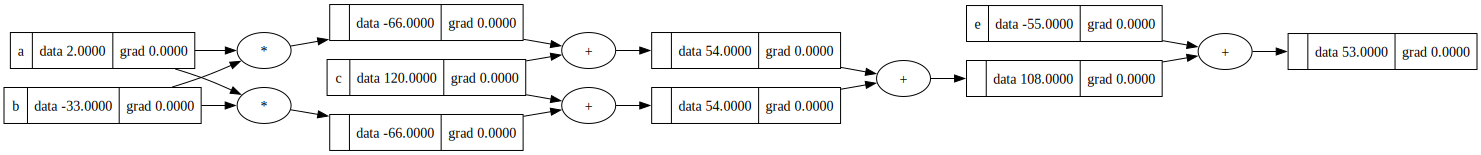

In [12]:
draw_dot(d)

Right now we can do multiplicaton and addition, but not much else yet.

Now we will learn to calculate the derivatives.

In [ ]:
L = d * f
dL/dd = f